# In this notebook we implement the 'Diagonal Thresholding' algorithm for sparse PCA as described in https://www.tandfonline.com/doi/pdf/10.1198/jasa.2009.0121 . 

In [207]:
using Plots, LinearAlgebra, Random, Distributions, Statistics, MultivariateStats, StatsBase

In [208]:
# Produces an i.i.d sample of size n from the d-dimensional spiked covariance ensemble 
# with principal eigenvector ∝ (1, 1, ..., 1, 0, 0, .. 0)
function spikedSample(s, d, n)
    # Constructing the principal eigenvector
    θ = [sqrt(s)^(-1) for _ in 1:s]
    θ = vcat(θ, zeros(d - s))'
    # Generating a sample from the spiked covariance ensemble
    return θ .* rand(Normal(), n) + rand(Normal(), n, size(θ)[2])
end

# Given a Bitarray I of length n and sum m < n and a vector v of length m, returns v embedded into 
# Rⁿ by padding v with zeros at the coordinates specified by I
function embed(I, v)
    arr = zeros(length(I), size(v)[2])
    counter = 1
    for index = 1:length(I)
        if I[index]
            arr[index, :] = v[counter, :]
            counter += 1
        end
    end
    return arr
end

# Normalizes the columns of a matrix X
function normalize_columns(X)
    m = size(X)[2]
    for col = 1:m
        column = X[:, col]
        n = norm(column)
        if n != 0
            X[:, col] = column .* n^(-1)
        end
    end
    return X
end

normalize_columns (generic function with 1 method)

### The function below performs the SPCA algorithm and outputs estimates of the 's' largest eigenvectors of cov(X) where 's' is an estimate of the true sparsity

In [209]:
function SPCA(X, s)
    n = size(X)[1]
    d = size(X)[2]
    
     # Step 2.: finding the top variances and storing in I
#     vars = var(X, dims=1)
#     sortperm(vars)[end - s:end]
#     α = 0.5
#     σ² = median(vars)
#     cutoff = α * √(n\log(n))
#     I = vars .> σ² * (1 + cutoff)
#     k = sum(I)
    
    # Alternative step 2.: we just use the top 's' variances where 's' is our guess of the true sparsity parameter
    vars = var(X, dims=1)[1, :]
    indexes = sortperm(vars)[end - s + 1:end]
    I = [0 for _ = 1:d]
    I[indexes] .= 1
    I =  BitArray{1}(I)
    k = sum(I)
    

    # Step 3.: performing PCA on subset I of matrix
    Y = X[:, I[:]]
    Σ = cov(Y)

    # ef = eigen(Symmetric(Σ), k:k)
    ef = eigen(Symmetric(Σ))
    v = ef.vectors

    # Step 4.: thresholding the resulting eigenvectors
    τ = [mad(v[column, :], normalize = false) for column = 1:size(v)[2]].*(0.6745^(-1))*0.1
    v = v .* (broadcast(abs, v) .> (1* τ * √(2 * log(k)))*0)
    v = normalize_columns(v)

    # Step 5.: returning to original dimension
    u = embed(I, v);
end

SPCA (generic function with 1 method)

### Below we perform some experiments where we compare the performance of regular PCA and sparse PCA on a synthetic sample from the spiked covariance ensemble with sparsity 5 and principal eigenvector proportional to (1, 1, 1, 1, 1, 0, 0, ..., 0). For all our experiments dim = n i.e. the number of dimensions is equal to the number of samples observed (i.e. high dimensional setting) and we vary their common value between 10 and 3000. Note that we assume that the true sparsity s = 5 is known to us. 

In [210]:
# Sparsity of the principal eigenvector
sparsity = 5
# Number of Monte Carlo experiments to do
nExp = [100 100 100 50 50 30 30 10 8 5 5 5]
# The grid over which the values of (d, n) vary
grid = [30 50 100 200 300 500 1000 2000 3000]
nGrid = length(grid)

sPCA = zeros(nGrid)
sVars = zeros(nGrid)
PCA = zeros(nGrid)
Vars = zeros(nGrid)

for (i, num) in enumerate(grid)
    # Monitoring progress
    println(string(i, " ", num))
    
    # Setting the number of samples and the dimension equal to 'num' 
    n = dim = num
    
    # Setting up containers for the experiments
    sTemp = zeros(nExp[i])
    Temp = zeros(nExp[i])
    
    # Setting up unit norm principal eigenvector supported on the first 'sparsity' coordinates
    θ = [sqrt(sparsity)^(-1) for _ in 1:sparsity]
    θ = vcat(θ, zeros(dim - sparsity))
    θ = [θ[i] for i = 1:length(θ)]
    
    # Performing Monte Carlo experiments
    for experiment = 1:nExp[i]
        X = spikedSample(sparsity, dim, n)
        V₁ = SPCA(X, sparsity)[:, end]
        V₂ = eigen(Symmetric(cov(X)), dim:dim).vectors[:]
        sTemp[experiment] = min(norm(V₁ - θ), norm(V₁ + θ))
        Temp[experiment] = min(norm(V₂ - θ), norm(V₂ + θ))
    end
    
    # Calculating the means and variances of the experimental data
    sPCA[i] = mean(sTemp)
    sVars[i] = var(sTemp)
    PCA[i] = mean(Temp)
    Vars[i] = var(Temp)
end

1 30
2 50
3 100
4 200
5 300
6 500
7 1000
8 2000
9 3000


### Now we plot the results of the experiment: for each value of n = dim we plot the average distance of the estimate to the true principal vector. 

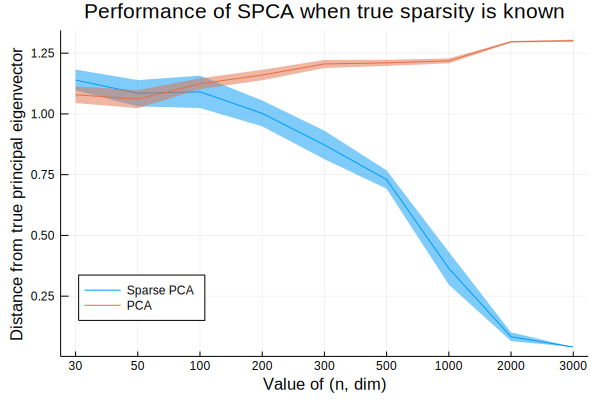

In [211]:
xs = [string(num) for num in grid][:]
plot(xs, [sPCA PCA], grid=true, title = "Performance of SPCA when true sparsity is known", ribbon = [sVars Vars], fillalpha=.5, legend = :bottomleft, label = ["Sparse PCA" "PCA"])
xlabel!("Value of (n, dim)")
ylabel!("Distance from true principal eigenvector")

### We perform the same experiment as before, except we don't assume the true sparsity is known precisely, only up to a factor of 10. 

In [212]:
# Sparsity of the principal eigenvector
sparsity = 5
# Number of Monte Carlo experiments to do
nExp = [100 100 100 50 50 30 30 10 8 5 5 5]
# The grid over which the values of (d, n) vary
grid = [30 50 100 200 300 500 1000 2000 3000]
nGrid = length(grid)

sPCA = zeros(nGrid)
sVars = zeros(nGrid)
PCA = zeros(nGrid)
Vars = zeros(nGrid)

for (i, num) in enumerate(grid)
    # Monitoring progress
    println(string(i, " ", num))
    
    # Setting the number of samples and the dimension equal to 'num' 
    n = dim = num
    
    # Setting up containers for the experiments
    sTemp = zeros(nExp[i])
    Temp = zeros(nExp[i])
    
    # Setting up unit norm principal eigenvector supported on the first 'sparsity' coordinates
    θ = [sqrt(sparsity)^(-1) for _ in 1:sparsity]
    θ = vcat(θ, zeros(dim - sparsity))
    θ = [θ[i] for i = 1:length(θ)]
    
    # Performing Monte Carlo experiments
    for experiment = 1:nExp[i]
        X = spikedSample(sparsity, dim, n)
        V₁ = SPCA(X, min(dim, sparsity))[:, end]
        V₂ = eigen(Symmetric(cov(X)), dim:dim).vectors[:]
        sTemp[experiment] = min(norm(V₁ - θ), norm(V₁ + θ))
        Temp[experiment] = min(norm(V₂ - θ), norm(V₂ + θ))
    end
    
    # Calculating the means and variances of the experimental data
    sPCA[i] = mean(sTemp)
    sVars[i] = var(sTemp)
    PCA[i] = mean(Temp)
    Vars[i] = var(Temp)
end

1 30
2 50
3 100
4 200
5 300
6 500
7 1000
8 2000
9 3000


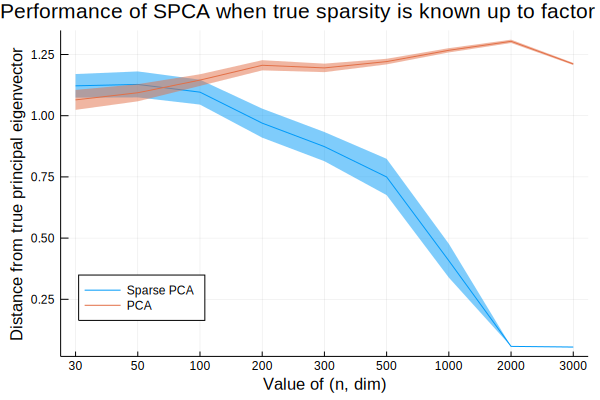

In [213]:
xs = [string(num) for num in grid][:]
plot(xs, [sPCA PCA], grid=true, title = "Performance of SPCA when true sparsity is known up to factor of 10", ribbon = [sVars Vars], fillalpha=.5, legend = :bottomleft, label = ["Sparse PCA" "PCA"])
xlabel!("Value of (n, dim)")
ylabel!("Distance from true principal eigenvector")